<a href="https://colab.research.google.com/github/ronandenyer/Mickey_Ninjas/blob/Time_Windows/Steinmetz_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting LFP data from pickled, pp'ed sets

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import scipy.signal as sp
import numpy as np
import pickle

In [ ]:
!pwd
!ls
%cd gdrive/MyDrive/repos/Mickey_Ninjas

/content
gdrive	sample_data
/content/gdrive/MyDrive/repos/Mickey_Ninjas


In [ ]:
with open('filtered_LFP.pkl', 'rb') as f:
    filt_dat_LFP = pickle.load(f)

# Loading Steinmetz SPIKING data

In [ ]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [ ]:
#@title Data loading

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [ ]:
# for each session, pull over the info from the spiking datasets to add to LFP
for isession in range(len(alldat)):
  # mouse name
  filt_dat_LFP[isession]['mouse_name'] = alldat[isession]['mouse_name']
  filt_dat_LFP[isession]['contrast_left'] = alldat[isession]['contrast_left']
  filt_dat_LFP[isession]['contrast_right'] = alldat[isession]['contrast_right']
  filt_dat_LFP[isession]['gocue'] = alldat[isession]['gocue']
  filt_dat_LFP[isession]['response'] = alldat[isession]['response']
  filt_dat_LFP[isession]['wheel'] = alldat[isession]['wheel']
  filt_dat_LFP[isession]['reaction_time'] = alldat[isession]['reaction_time']

# so as to not crash
del alldat

`dat_LFP`, `dat_WAV`, `dat_ST` contain 39 sessions from 10 mice, data from Steinmetz et al, 2019, supplemental to the main data provided for NMA. Time bins for all measurements are 10ms, starting 500ms before stimulus onset (same as the main data). The followin fields are available across the three supplemental files. 

* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['ss']`: neurons by trials. Exact spikes times for each neuron and each trial, reference to the stimulus onset. A (neuron,trial) entry can be an empty list if that neuron did not fire at all on that trial. 
* `dat['%X%_passive']`: same as above for `X` = {`lfp`, `ss`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 

Info added from spiking sets:
* `dat['mouse_name']`: mouse name
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  




# Check which brain regions in which LFP dataset (Darcy)

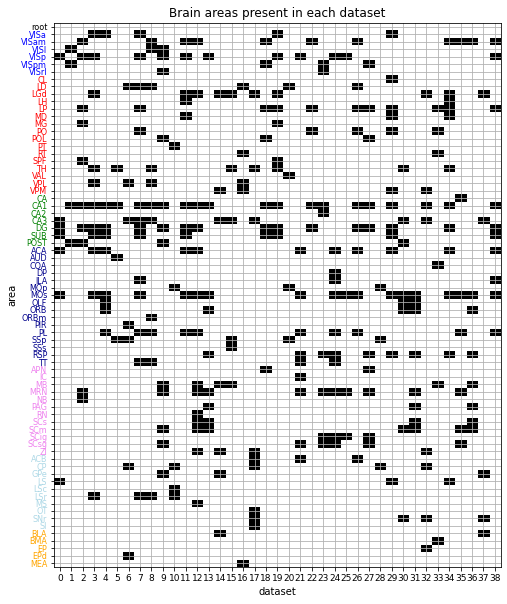

In [ ]:
# @title Make a plot of which brain areas are present in each dataset
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(filt_dat_LFP)), dtype=bool)
for j, d in enumerate(filt_dat_LFP):
    for area in np.unique(d['brain_area_lfp']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
    yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(filt_dat_LFP)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
    for area in group:
        ytickobjs[counter].set_color(color)
        counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)

# Time window code (Ronan)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


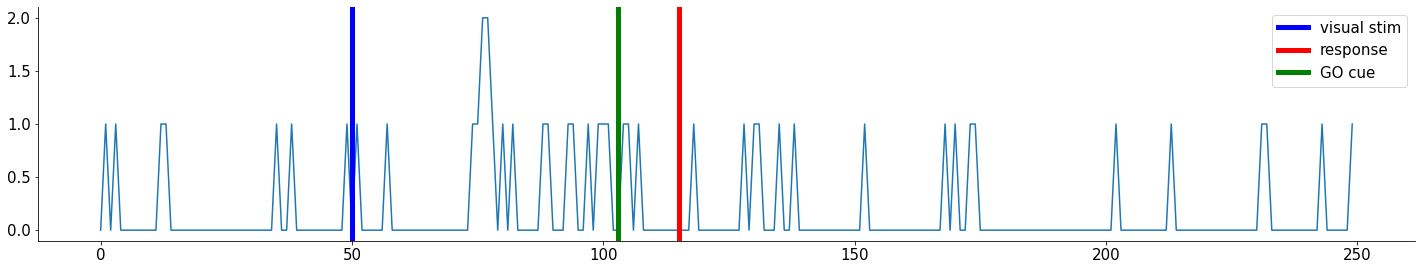

In [ ]:
# function to loop through trial data and create 2 x 1 array describing the time
# point at which visual stimulus was displayed and a second event within the 
# trial (e.g. response, go cue onset). Option to keep units in seconds or change
# to 10ms time bin format used by spike data

def time_window_generator(start_window_variable, end_window_variable, spike_rate_format=True):
  '''
  Creates a time window on visual stim onset to later trial event

  Args:
    start_window_variable (float)               : fixed value for visual stim onset (s)
    end_window_variable (numpy array of floats) : array of second event times per trial (s)
    spike_rate_format (boolean)                 : boolean whether to calculate in 10ms bins
  
  Returns:
    numpy array of floats

  '''
  number_trials = len(end_window_variable) #loop through number of trials per session
  start_window = start_window_variable
  time_window = np.zeros((number_trials, 2)) #initialize time_window variable
  
  
  for trial in range(number_trials):
    time_window[trial] = np.array([start_window, end_window_variable[trial]]) * 100
    
  if spike_rate_format:
    time_window = np.round(time_window)


  return time_window

for session in range(len(alldat)):
  
  dat = alldat[session]
  dat['stim_response_time_window'] = time_window_generator(dat['stim_onset'], dat['response_time'])
  dat['stim_gocue_time_window'] = time_window_generator(dat['stim_onset'], dat['gocue'])
  

# example plot of time windows on single trial
plt.plot(alldat[0]['spks'][670][0])
plt.axvline(alldat[0]['stim_response_time_window'][0][0], color='blue', linewidth=5, label = 'visual stim')
plt.axvline(alldat[0]['stim_response_time_window'][0][1], color='red', linewidth=5, label='response')
plt.axvline(alldat[0]['stim_gocue_time_window'][0][1], color='green', linewidth=5, label='GO cue')
plt.legend()








# Time-frequency conversion function using multitaper/welch from https://raphaelvallat.com/bandpower.html

In [ ]:
def bandpower(data, sf, band, method='welch', window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        freqs, psd = welch(data, sf, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True,
                                          normalization='full', verbose=0)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp


# Use on LFP data to extract beta